<a href="https://colab.research.google.com/github/Dipendra7/2015lab1/blob/master/SNN_Pong_DQN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!nvidia-smi
!pip install "gym[atari, accept-rom-license]"

Sun Sep 15 20:04:10 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   48C    P8              10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
import gym
import gym.spaces

DEFAULT_ENV_NAME = "PongNoFrameskip-v4"
test_env = gym.make(DEFAULT_ENV_NAME)
print(test_env.action_space.n)

6


/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


In [3]:
print(test_env.unwrapped.get_action_meanings())

['NOOP', 'FIRE', 'RIGHT', 'LEFT', 'RIGHTFIRE', 'LEFTFIRE']


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [4]:
print(test_env.observation_space.shape)

(210, 160, 3)


In [5]:
!nvidia-smi

Sun Sep 15 20:04:24 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   46C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [6]:
import warnings
warnings.filterwarnings('ignore')

In [7]:
# Taken from
# https://github.com/PacktPublishing/Deep-Reinforcement-Learning-Hands-On/blob/master/Chapter06/lib/wrappers.py

import cv2
import numpy as np
import collections

class FireResetEnv(gym.Wrapper):
    def __init__(self, env=None):
        super(FireResetEnv, self).__init__(env)
        assert env.unwrapped.get_action_meanings()[1] == 'FIRE'
        assert len(env.unwrapped.get_action_meanings()) >= 3

    def step(self, action):
        return self.env.step(action)

    def reset(self):
        self.env.reset()
        obs, _, done, _ = self.env.step(1)
        if done:
            self.env.reset()
        obs, _, done, _ = self.env.step(2)
        if done:
            self.env.reset()
        return obs

class MaxAndSkipEnv(gym.Wrapper):
    def __init__(self, env=None, skip=4):
        super(MaxAndSkipEnv, self).__init__(env)
        # most recent raw observations (for max pooling across time steps)
        self._obs_buffer = collections.deque(maxlen=2)
        self._skip = skip

    def step(self, action):
        total_reward = 0.0
        done = None
        for _ in range(self._skip):
            obs, reward, done, info = self.env.step(action)
            self._obs_buffer.append(obs)
            total_reward += reward
            if done:
                break
        max_frame = np.max(np.stack(self._obs_buffer), axis=0)
        return max_frame, total_reward, done, info

    def reset(self):
        self._obs_buffer.clear()
        obs = self.env.reset()
        self._obs_buffer.append(obs)
        return obs


class ProcessFrame84(gym.ObservationWrapper):
    def __init__(self, env=None):
        super(ProcessFrame84, self).__init__(env)
        self.observation_space = gym.spaces.Box(low=0, high=255, shape=(84, 84, 1), dtype=np.uint8)

    def observation(self, obs):
        return ProcessFrame84.process(obs)

    @staticmethod
    def process(frame):
        if frame.size == 210 * 160 * 3:
            img = np.reshape(frame, [210, 160, 3]).astype(np.float32)
        elif frame.size == 250 * 160 * 3:
            img = np.reshape(frame, [250, 160, 3]).astype(np.float32)
        else:
            assert False, "Unknown resolution."
        img = img[:, :, 0] * 0.299 + img[:, :, 1] * 0.587 + img[:, :, 2] * 0.114
        resized_screen = cv2.resize(img, (84, 110), interpolation=cv2.INTER_AREA)
        x_t = resized_screen[18:102, :]
        x_t = np.reshape(x_t, [84, 84, 1])
        return x_t.astype(np.uint8)


class BufferWrapper(gym.ObservationWrapper):
    def __init__(self, env, n_steps, dtype=np.float32):
        super(BufferWrapper, self).__init__(env)
        self.dtype = dtype
        old_space = env.observation_space
        self.observation_space = gym.spaces.Box(old_space.low.repeat(n_steps, axis=0),
                                                old_space.high.repeat(n_steps, axis=0), dtype=dtype)

    def reset(self):
        self.buffer = np.zeros_like(self.observation_space.low, dtype=self.dtype)
        return self.observation(self.env.reset())

    def observation(self, observation):
        self.buffer[:-1] = self.buffer[1:]
        self.buffer[-1] = observation
        return self.buffer


class ImageToPyTorch(gym.ObservationWrapper):
    def __init__(self, env):
        super(ImageToPyTorch, self).__init__(env)
        old_shape = self.observation_space.shape
        self.observation_space = gym.spaces.Box(low=0.0, high=1.0, shape=(old_shape[-1],
                                old_shape[0], old_shape[1]), dtype=np.float32)

    def observation(self, observation):
        return np.moveaxis(observation, 2, 0)


class ScaledFloatFrame(gym.ObservationWrapper):
    def observation(self, obs):
        return np.array(obs).astype(np.float32) / 255.0

def make_env(env_name):
    env = gym.make(env_name)
    env = MaxAndSkipEnv(env)
    env = FireResetEnv(env)
    env = ProcessFrame84(env)
    env = ImageToPyTorch(env)
    env = BufferWrapper(env, 4)
    return ScaledFloatFrame(env)

In [8]:
import torch
import torch.nn as nn        # Pytorch neural network package
import torch.optim as optim  # Pytorch optimization package

device = torch.device("cpu")
if torch.cuda.is_available():
    device = torch.device("cuda")

In [9]:
# Taken from
# https://github.com/PacktPublishing/Deep-Reinforcement-Learning-Hands-On/blob/master/Chapter06/lib/dqn_model.py

import numpy as np

class DQN(nn.Module):
    def __init__(self, input_shape, n_actions):
        super(DQN, self).__init__()

        self.conv = nn.Sequential(
            nn.Conv2d(input_shape[0], 32, kernel_size=8, stride=4),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1),
            nn.ReLU()
        )

        conv_out_size = self._get_conv_out(input_shape)
        self.fc = nn.Sequential(
            nn.Linear(conv_out_size, 512),
            nn.ReLU(),
            nn.Linear(512, n_actions)
        )

    def _get_conv_out(self, shape):
        o = self.conv(torch.zeros(1, *shape))
        return int(np.prod(o.size()))

    def forward(self, x):
        conv_out = self.conv(x).view(x.size()[0], -1)
        return self.fc(conv_out)

In [10]:
test_env = make_env(DEFAULT_ENV_NAME)
test_net = DQN(test_env.observation_space.shape, test_env.action_space.n).to(device)
print(test_net)

DQN(
  (conv): Sequential(
    (0): Conv2d(4, 32, kernel_size=(8, 8), stride=(4, 4))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2))
    (3): ReLU()
    (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (5): ReLU()
  )
  (fc): Sequential(
    (0): Linear(in_features=3136, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=6, bias=True)
  )
)


SNN Implementation

In [11]:
%pip install snntorch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 125.3/125.3 kB 8.0 MB/s eta 0:00:00


In [12]:
import snntorch as snn
from snntorch import spikeplot as splt
from snntorch import spikegen
import torch
import torch.nn as nn
import numpy as np

Architecture 1

In [13]:
#Inspired From

#https://github.com/sofi12321/SNN_image_classification/blob/main/SNN_image_classification.ipynb


class SNN_Arch(nn.Module):
    def __init__(self, num_inputs, num_outputs,
                 num_hidden=1024, num_steps=25,
                 beta=0.95):
        """
        SNN with one hidden layer

        :param num_inputs: number of input units
        :param num_outputs: number of output units
        :param num_hidden: number of hidden units
        :param num_steps: number of time steps
        :param beta: beta coefficient value for Leaky model
        """
        super(SNN_Arch, self).__init__()

        # Initialize layers
        self.linear1 = nn.Linear(num_inputs, num_hidden)
        self.lif1 = snn.Leaky(beta=beta)
        self.linear2 = nn.Linear(num_hidden, num_outputs)
        self.lif2 = snn.Leaky(beta=beta)

        # Initialize number of time steps
        self.num_steps = num_steps

    def forward(self, x):
        """
        Forward step

        :param x: input values
        :return: output spikes and membrane potential
        """
        # Initialize hidden states at t=0
        potential1 = self.lif1.init_leaky()
        potential2 = self.lif2.init_leaky()

        # Record the output values
        output_spike = []
        output_potential = []

        for step in range(self.num_steps):
            # For each time step run through the SNN
            current1 = self.linear1(x)
            spike1, potential1 = self.lif1(current1, potential1)
            current2 = self.linear2(spike1)
            spike2, potential2 = self.lif2(current2, potential2)

            # Record outputs
            output_spike.append(spike2)
            output_potential.append(potential2)
        return torch.stack(output_spike, dim=0), torch.stack(output_potential, dim=0)


# SNN
class SNN(nn.Module):
    def __init__(self, input_shape, n_actions,
                 num_hidden=1024, num_steps=25, beta=0.95):
        """
        DQN architecture using Spiking Neural Network (SNN)
        :param input_shape: shape of the input
        :param n_actions: number of output actions
        """
        super(SNN, self).__init__()

        # Flatten input from the Conv layers into a 1D input vector for SNN
        self.conv = nn.Sequential(
            nn.Conv2d(input_shape[0], 32, kernel_size=8, stride=4),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1),
            nn.ReLU()
        )

        conv_out_size = self._get_conv_out(input_shape)

        # SNN replacing the fully connected layers in DQN
        self.snn = SNN_Arch(conv_out_size, n_actions, num_hidden, num_steps, beta)

    def _get_conv_out(self, shape):
        # Function to compute the output size of the conv layers
        o = self.conv(torch.zeros(1, *shape))
        return int(np.prod(o.size()))

    def forward(self, x):
        # Pass through the conv layers
        conv_out = self.conv(x).view(x.size()[0], -1)

        # Pass through the SNN
        spike_out, potential_out = self.snn(conv_out)

        # Return the final membrane potential (last timestep) as output
        return potential_out[-1]


In [14]:
# Create the environment
test_env = make_env(DEFAULT_ENV_NAME)

# Define the input and output shapes
input_shape = test_env.observation_space.shape  # Same input shape as the DQN
n_actions = test_env.action_space.n             # Number of possible actions

# Instantiate the SNN model (you can adjust num_hidden, num_steps, and beta as needed)
test_net = SNN(input_shape, n_actions, num_hidden=128, num_steps=10, beta=0.9).to(device)

# Print the network architecture
print(test_net)


SNN(
  (conv): Sequential(
    (0): Conv2d(4, 32, kernel_size=(8, 8), stride=(4, 4))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2))
    (3): ReLU()
    (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (5): ReLU()
  )
  (snn): SNN_Arch(
    (linear1): Linear(in_features=3136, out_features=128, bias=True)
    (lif1): Leaky()
    (linear2): Linear(in_features=128, out_features=6, bias=True)
    (lif2): Leaky()
  )
)


In [15]:
from torch.utils.tensorboard import SummaryWriter
%load_ext tensorboard

In [16]:
import time
import numpy as np
import collections


MEAN_REWARD_BOUND = 19.0

gamma = 0.99
batch_size = 32
replay_size = 10000
learning_rate = 1e-4
sync_target_frames = 1000
replay_start_size = 10000

eps_start=1.0
eps_decay=.999985
eps_min=0.02

In [17]:
Experience = collections.namedtuple('Experience', field_names=['state', 'action', 'reward', 'done', 'new_state'])

class ExperienceReplay:
    def __init__(self, capacity):
        self.buffer = collections.deque(maxlen=capacity)

    def __len__(self):
        return len(self.buffer)

    def append(self, experience):
        self.buffer.append(experience)

    def sample(self, batch_size):
        indices = np.random.choice(len(self.buffer), batch_size, replace=False)
        states, actions, rewards, dones, next_states = zip(*[self.buffer[idx] for idx in indices])
        return np.array(states), np.array(actions), np.array(rewards, dtype=np.float32), \
               np.array(dones, dtype=np.uint8), np.array(next_states)

In [18]:
class Agent:
    def __init__(self, env, exp_buffer):
        self.env = env
        self.exp_buffer = exp_buffer
        self._reset()

    def _reset(self):
        self.state = env.reset()
        self.total_reward = 0.0

    def play_step(self, net, epsilon=0.0, device="cpu"):

        done_reward = None
        if np.random.random() < epsilon:
            action = env.action_space.sample()
        else:
            state_a = np.array([self.state], copy=False)
            state_v = torch.tensor(state_a).to(device)
            q_vals_v = net(state_v)
            _, act_v = torch.max(q_vals_v, dim=1)
            action = int(act_v.item())

        new_state, reward, is_done, _ = self.env.step(action)
        self.total_reward += reward

        exp = Experience(self.state, action, reward, is_done, new_state)
        self.exp_buffer.append(exp)
        self.state = new_state
        if is_done:
            done_reward = self.total_reward
            self._reset()
        return done_reward

In [19]:
import datetime
print(">>>Training starts at ",datetime.datetime.now())

>>>Training starts at  2024-09-15 20:04:35.776070


In [20]:
import datetime
print(">>>Training starts at ",datetime.datetime.now())
env = make_env(DEFAULT_ENV_NAME)

# net = DQN(env.observation_space.shape, env.action_space.n).to(device)
# target_net = DQN(env.observation_space.shape, env.action_space.n).to(device)

net = SNN(env.observation_space.shape, env.action_space.n).to(device)
target_net = SNN(env.observation_space.shape, env.action_space.n).to(device)

writer = SummaryWriter(comment="-" + DEFAULT_ENV_NAME)

buffer = ExperienceReplay(replay_size)
agent = Agent(env, buffer)

epsilon = eps_start

optimizer = optim.Adam(net.parameters(), lr=learning_rate)
total_rewards = []
frame_idx = 0

best_mean_reward = None



>>>Training starts at  2024-09-15 20:04:35.787155


883:  1 games, mean reward -21.000, (epsilon 0.99)
Best mean reward updated -21.000
1758:  2 games, mean reward -21.000, (epsilon 0.97)
2686:  3 games, mean reward -20.667, (epsilon 0.96)
Best mean reward updated -20.667
3659:  4 games, mean reward -20.750, (epsilon 0.95)
4578:  5 games, mean reward -20.600, (epsilon 0.93)
Best mean reward updated -20.600
5429:  6 games, mean reward -20.667, (epsilon 0.92)
6393:  7 games, mean reward -20.571, (epsilon 0.91)
Best mean reward updated -20.571
7407:  8 games, mean reward -20.500, (epsilon 0.89)
Best mean reward updated -20.500
8535:  9 games, mean reward -20.444, (epsilon 0.88)
Best mean reward updated -20.444
9461:  10 games, mean reward -20.400, (epsilon 0.87)
Best mean reward updated -20.400
10422:  11 games, mean reward -20.364, (epsilon 0.86)
Best mean reward updated -20.364
11330:  12 games, mean reward -20.417, (epsilon 0.84)
12311:  13 games, mean reward -20.385, (epsilon 0.83)
13495:  14 games, mean reward -20.286, (epsilon 0.82)


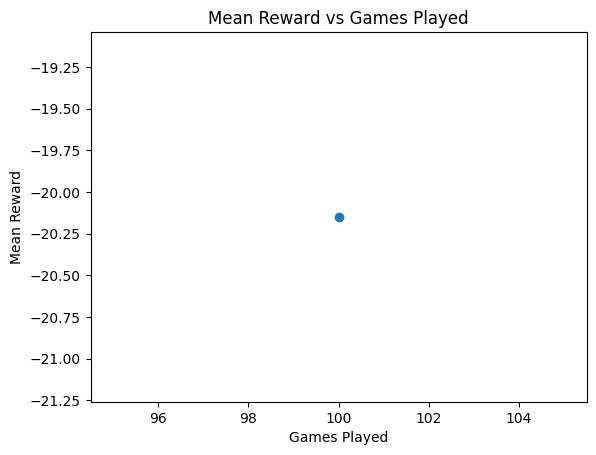

96286:  100 games, mean reward -20.150, (epsilon 0.24)
97518:  101 games, mean reward -20.130, (epsilon 0.23)
98281:  102 games, mean reward -20.130, (epsilon 0.23)
99247:  103 games, mean reward -20.140, (epsilon 0.23)
100341:  104 games, mean reward -20.130, (epsilon 0.22)
101641:  105 games, mean reward -20.120, (epsilon 0.22)
102803:  106 games, mean reward -20.090, (epsilon 0.21)
103761:  107 games, mean reward -20.100, (epsilon 0.21)
104902:  108 games, mean reward -20.090, (epsilon 0.21)
106031:  109 games, mean reward -20.080, (epsilon 0.20)
107022:  110 games, mean reward -20.080, (epsilon 0.20)
107935:  111 games, mean reward -20.090, (epsilon 0.20)
108775:  112 games, mean reward -20.080, (epsilon 0.20)
109906:  113 games, mean reward -20.080, (epsilon 0.19)
110912:  114 games, mean reward -20.100, (epsilon 0.19)
112082:  115 games, mean reward -20.100, (epsilon 0.19)
113147:  116 games, mean reward -20.110, (epsilon 0.18)
114350:  117 games, mean reward -20.090, (epsilon 0.

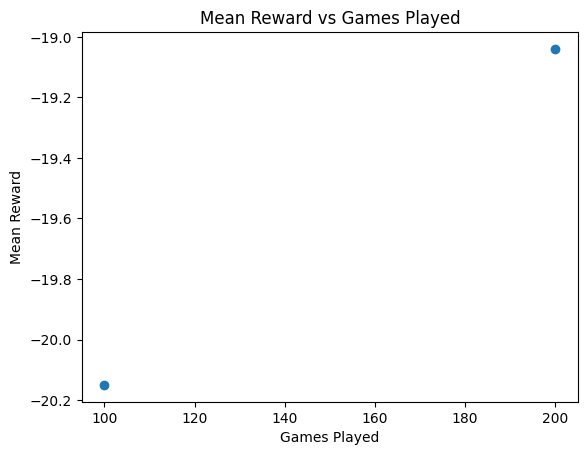

220062:  200 games, mean reward -19.040, (epsilon 0.04)
221355:  201 games, mean reward -19.030, (epsilon 0.04)
Best mean reward updated -19.030
222720:  202 games, mean reward -19.020, (epsilon 0.04)
Best mean reward updated -19.020
223669:  203 games, mean reward -19.020, (epsilon 0.03)
224923:  204 games, mean reward -19.030, (epsilon 0.03)
226211:  205 games, mean reward -19.020, (epsilon 0.03)
227698:  206 games, mean reward -19.030, (epsilon 0.03)
229102:  207 games, mean reward -19.020, (epsilon 0.03)
230673:  208 games, mean reward -19.000, (epsilon 0.03)
Best mean reward updated -19.000
231744:  209 games, mean reward -19.020, (epsilon 0.03)
233072:  210 games, mean reward -19.030, (epsilon 0.03)
234125:  211 games, mean reward -19.020, (epsilon 0.03)
235290:  212 games, mean reward -19.010, (epsilon 0.03)
236535:  213 games, mean reward -18.980, (epsilon 0.03)
Best mean reward updated -18.980
237934:  214 games, mean reward -18.950, (epsilon 0.03)
Best mean reward updated -18

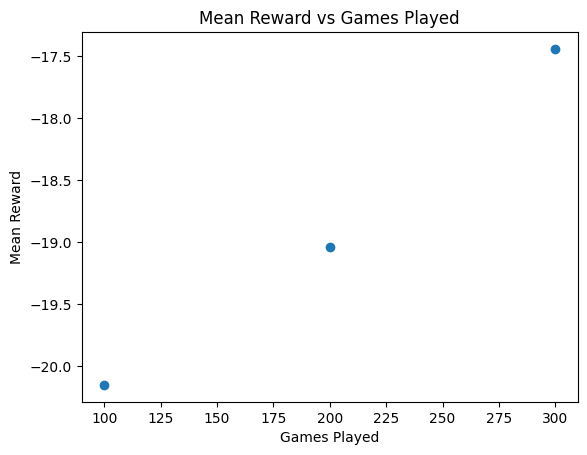

372988:  300 games, mean reward -17.440, (epsilon 0.02)
Best mean reward updated -17.440
374784:  301 games, mean reward -17.400, (epsilon 0.02)
Best mean reward updated -17.400
376420:  302 games, mean reward -17.340, (epsilon 0.02)
Best mean reward updated -17.340
377818:  303 games, mean reward -17.290, (epsilon 0.02)
Best mean reward updated -17.290
379242:  304 games, mean reward -17.240, (epsilon 0.02)
Best mean reward updated -17.240
381027:  305 games, mean reward -17.210, (epsilon 0.02)
Best mean reward updated -17.210
382991:  306 games, mean reward -17.130, (epsilon 0.02)
Best mean reward updated -17.130
384809:  307 games, mean reward -17.060, (epsilon 0.02)
Best mean reward updated -17.060
386381:  308 games, mean reward -17.040, (epsilon 0.02)
Best mean reward updated -17.040
387792:  309 games, mean reward -16.990, (epsilon 0.02)
Best mean reward updated -16.990
389434:  310 games, mean reward -16.920, (epsilon 0.02)
Best mean reward updated -16.920
390957:  311 games, m

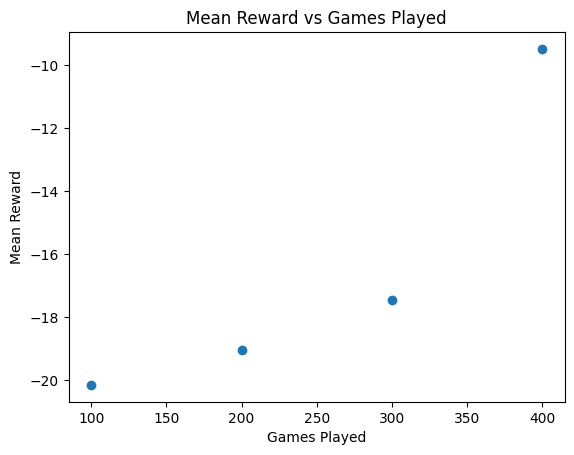

583703:  400 games, mean reward -9.490, (epsilon 0.02)
Best mean reward updated -9.490
586464:  401 games, mean reward -9.390, (epsilon 0.02)
Best mean reward updated -9.390
589037:  402 games, mean reward -9.300, (epsilon 0.02)
Best mean reward updated -9.300
591758:  403 games, mean reward -9.180, (epsilon 0.02)
Best mean reward updated -9.180
594458:  404 games, mean reward -8.940, (epsilon 0.02)
Best mean reward updated -8.940
597151:  405 games, mean reward -8.850, (epsilon 0.02)
Best mean reward updated -8.850
599335:  406 games, mean reward -8.850, (epsilon 0.02)
601752:  407 games, mean reward -8.780, (epsilon 0.02)
Best mean reward updated -8.780
604335:  408 games, mean reward -8.590, (epsilon 0.02)
Best mean reward updated -8.590
607420:  409 games, mean reward -8.420, (epsilon 0.02)
Best mean reward updated -8.420
609741:  410 games, mean reward -8.190, (epsilon 0.02)
Best mean reward updated -8.190
612133:  411 games, mean reward -7.950, (epsilon 0.02)
Best mean reward upd

In [ ]:
import matplotlib.pyplot as plt

mean_rewards = []
games_played = []

while True:
        frame_idx += 1
        epsilon = max(epsilon*eps_decay, eps_min)

        reward = agent.play_step(net, epsilon, device=device)
        if reward is not None:
            total_rewards.append(reward)

            if len(total_rewards) % 100 == 0:
                mean_rewards.append(np.mean(total_rewards[-100:]))
                games_played.append(len(total_rewards))

                plt.scatter(games_played, mean_rewards)
                plt.xlabel('Games Played')
                plt.ylabel('Mean Reward')
                plt.title('Mean Reward vs Games Played')
                plt.show()

            mean_reward = np.mean(total_rewards[-100:])

            print("%d:  %d games, mean reward %.3f, (epsilon %.2f)" % (
                frame_idx, len(total_rewards), mean_reward, epsilon))

            writer.add_scalar("epsilon", epsilon, frame_idx)
            writer.add_scalar("reward_100", mean_reward, frame_idx)
            writer.add_scalar("reward", reward, frame_idx)

            if best_mean_reward is None or best_mean_reward < mean_reward:
                torch.save(net.state_dict(), DEFAULT_ENV_NAME + "-best.dat")
                best_mean_reward = mean_reward
                if best_mean_reward is not None:
                    print("Best mean reward updated %.3f" % (best_mean_reward))

            if mean_reward > MEAN_REWARD_BOUND:
                print("Solved in %d frames!" % frame_idx)
                break

        if len(buffer) < replay_start_size:
            continue

        batch = buffer.sample(batch_size)
        states, actions, rewards, dones, next_states = batch

        states_v = torch.tensor(states).to(device)
        next_states_v = torch.tensor(next_states).to(device)
        actions_v = torch.tensor(actions).to(device)
        rewards_v = torch.tensor(rewards).to(device)
        #done_mask = torch.ByteTensor(dones).to(device)
        done_mask = torch.BoolTensor(dones).to(device) # Change to BoolTensor instead of ByteTensor

        state_action_values = net(states_v).gather(1, actions_v.unsqueeze(-1)).squeeze(-1)

        next_state_values = target_net(next_states_v).max(1)[0]

        next_state_values[done_mask] = 0.0

        next_state_values = next_state_values.detach()

        expected_state_action_values = next_state_values * gamma + rewards_v

        loss_t = nn.MSELoss()(state_action_values, expected_state_action_values)

        optimizer.zero_grad()
        loss_t.backward()
        optimizer.step()

        if frame_idx % sync_target_frames == 0:
            target_net.load_state_dict(net.state_dict())

writer.close()

Architecture 2

In [ ]:
import datetime
print(">>>Training starts at ",datetime.datetime.now())

In [ ]:
while True:
        frame_idx += 1
        epsilon = max(epsilon*eps_decay, eps_min)

        reward = agent.play_step(net, epsilon, device=device)
        if reward is not None:
            total_rewards.append(reward)

            mean_reward = np.mean(total_rewards[-100:])

            print("%d:  %d games, mean reward %.3f, (epsilon %.2f)" % (
                frame_idx, len(total_rewards), mean_reward, epsilon))

            writer.add_scalar("epsilon", epsilon, frame_idx)
            writer.add_scalar("reward_100", mean_reward, frame_idx)
            writer.add_scalar("reward", reward, frame_idx)

            if best_mean_reward is None or best_mean_reward < mean_reward:
                torch.save(net.state_dict(), DEFAULT_ENV_NAME + "-best.dat")
                best_mean_reward = mean_reward
                if best_mean_reward is not None:
                    print("Best mean reward updated %.3f" % (best_mean_reward))

            if mean_reward > MEAN_REWARD_BOUND:
                print("Solved in %d frames!" % frame_idx)
                break

        if len(buffer) < replay_start_size:
            continue

        batch = buffer.sample(batch_size)
        states, actions, rewards, dones, next_states = batch

        states_v = torch.tensor(states).to(device)
        next_states_v = torch.tensor(next_states).to(device)
        actions_v = torch.tensor(actions).to(device)
        rewards_v = torch.tensor(rewards).to(device)
        #done_mask = torch.ByteTensor(dones).to(device)
        done_mask = torch.BoolTensor(dones).to(device) # Change to BoolTensor instead of ByteTensor

        state_action_values = net(states_v).gather(1, actions_v.unsqueeze(-1)).squeeze(-1)

        next_state_values = target_net(next_states_v).max(1)[0]

        next_state_values[done_mask] = 0.0

        next_state_values = next_state_values.detach()

        expected_state_action_values = next_state_values * gamma + rewards_v

        loss_t = nn.MSELoss()(state_action_values, expected_state_action_values)

        optimizer.zero_grad()
        loss_t.backward()
        optimizer.step()

        if frame_idx % sync_target_frames == 0:
            target_net.load_state_dict(net.state_dict())

writer.close()

############################################################################################

In [ ]:
environment = gym.make(ENVIRONMENT)  # Get env
agent = Agent(environment)  # Create Agent

if LOAD_MODEL_FROM_FILE:
    agent.online_model.load_state_dict(torch.load(MODEL_PATH+str(LOAD_FILE_EPISODE)+".pkl"))

    with open(MODEL_PATH+str(LOAD_FILE_EPISODE)+'.json') as outfile:
        param = json.load(outfile)
        agent.epsilon = param.get('epsilon')

    startEpisode = LOAD_FILE_EPISODE + 1

else:
    startEpisode = 1

last_100_ep_reward = deque(maxlen=100)  # Last 100 episode rewards
total_step = 1  # Cumulkative sum of all steps in episodes
for episode in range(startEpisode, MAX_EPISODE):

    startTime = time.time()  # Keep time
    state = environment.reset()  # Reset env

    state = agent.preProcess(state)  # Process image

    # Stack state . Every state contains 4 time contionusly frames
    # We stack frames like 4 channel image
    state = np.stack((state, state, state, state))

    total_max_q_val = 0  # Total max q vals
    total_reward = 0  # Total reward for each episode
    total_loss = 0  # Total loss for each episode
    for step in range(MAX_STEP):

        if RENDER_GAME_WINDOW:
            environment.render()  # Show state visually

        # Select and perform an action
        action = agent.act(state)  # Act
        next_state, reward, done, info = environment.step(action)  # Observe

        next_state = agent.preProcess(next_state)  # Process image

        # Stack state . Every state contains 4 time contionusly frames
        # We stack frames like 4 channel image
        next_state = np.stack((next_state, state[0], state[1], state[2]))

        # Store the transition in memory
        agent.storeResults(state, action, reward, next_state, done)  # Store to mem

        # Move to the next state
        state = next_state  # Update state

        if TRAIN_MODEL:
            # Perform one step of the optimization (on the target network)
            loss, max_q_val = agent.train()  # Train with random BATCH_SIZE state taken from mem
        else:
            loss, max_q_val = [0, 0]

        total_loss += loss
        total_max_q_val += max_q_val
        total_reward += reward
        total_step += 1
        if total_step % 1000 == 0:
            agent.adaptiveEpsilon()  # Decrase epsilon

        if done:  # Episode completed
            currentTime = time.time()  # Keep current time
            time_passed = currentTime - startTime  # Find episode duration
            current_time_format = time.strftime("%H:%M:%S", time.gmtime())  # Get current dateTime as HH:MM:SS
            epsilonDict = {'epsilon': agent.epsilon}  # Create epsilon dict to save model as file

            if SAVE_MODELS and episode % SAVE_MODEL_INTERVAL == 0:  # Save model as file
                weightsPath = MODEL_PATH + str(episode) + '.pkl'
                epsilonPath = MODEL_PATH + str(episode) + '.json'

                torch.save(agent.online_model.state_dict(), weightsPath)
                with open(epsilonPath, 'w') as outfile:
                    json.dump(epsilonDict, outfile)

            if TRAIN_MODEL:
                agent.target_model.load_state_dict(agent.online_model.state_dict())  # Update target model

            last_100_ep_reward.append(total_reward)
            avg_max_q_val = total_max_q_val / step

            outStr = "Episode:{} Time:{} Reward:{:.2f} Loss:{:.2f} Last_100_Avg_Rew:{:.3f} Avg_Max_Q:{:.3f} Epsilon:{:.2f} Duration:{:.2f} Step:{} CStep:{}".format(
                episode, current_time_format, total_reward, total_loss, np.mean(last_100_ep_reward), avg_max_q_val, agent.epsilon, time_passed, step, total_step
            )

            print(outStr)

            if SAVE_MODELS:
                outputPath = MODEL_PATH + "out" + '.txt'  # Save outStr to file
                with open(outputPath, 'a') as outfile:
                    outfile.write(outStr+"\n")

            break

In [ ]:
!pip install optuna
import optuna

In [ ]:
def train(environment, policy, optimizer, discount_factor, something): # Placeholder for your train function
    # Calculate loss and train_reward here
    # This is just a placeholder, replace this with your actual implementation
    loss = 0
    train_reward = 0
    return loss, train_reward

In [ ]:
def objective(trial):
    # Calculate input dimension based on environment and preprocessing
    environment = gym.make(ENVIRONMENT)  # Get env
    state_size_h = environment.observation_space.shape[0]
    state_size_w = environment.observation_space.shape[1]
    target_h = 80  # Height after process
    target_w = 64  # Widht after process
    INPUT_DIM = int((target_h / 4) * (target_w / 4) * 64)  # Calculate input dimension

    # Suggest hyperparameters
    OUTPUT_DIM = environment.action_space.n  # Output dimension based on action space
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    learning_rate = trial.suggest_float("learning_rate", 1e-5, 1e-1, log=True)
    hidden_dim = trial.suggest_int("hidden_dim", 256, 1024)
    dropout = trial.suggest_float("dropout", 0.1, 0.8)

    # Initialize model, optimizer with suggested hyperparameters
    policy = SNN(target_h, target_w, OUTPUT_DIM, dropout).to(device) # Use target_h and target_w here
    policy.apply(init_weights)
    optimizer = optim.Adam(policy.parameters(), lr=learning_rate)

    # Training loop (simplified for brevity)
    MAX_EPISODES = 100
    DISCOUNT_FACTOR = 0.99
    for episode in range(1, MAX_EPISODES + 1):
        loss, train_reward = train(environment, policy, optimizer, DISCOUNT_FACTOR, []) # Use environment here

        # Evaluate on validation set - Replace this with your actual validation logic
        #validation_reward = evaluate(environment, policy) # Example: Assuming you have a validation_env
        validation_reward = 0
        trial.report(validation_reward, episode)

        if trial.should_prune():
            raise optuna.TrialPruned()

    return validation_reward

In [ ]:
# Define init_weights function
def init_weights(m):
    if type(m) == nn.Linear or type(m) == nn.Conv2d:
        torch.nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.01)

In [ ]:
study = optuna.create_study(direction="maximize")  # Maximize validation reward
study.optimize(objective, n_trials=500)  # Run 100 trials